# Logistic Regression

In [96]:
%run 'setup_notebook.ipynb'

In [97]:
%run 'visualization_utilities.ipynb'

## Split input dataset into training, validation, and test datasets 

In [98]:
positive_class, negative_class

('>50K', '<=50K')

In [99]:
display_partitioning(y_train, y_validation, y_test, positive_class, negative_class)


Training dataset
   Size: 24128
   positive/negative ratio: 0.329


Validation dataset
   Size: 6033
   positive/negative ratio: 0.340


Test dataset
   Size: 15061
   positive/negative ratio: 0.326



## Map target classes from strings to  integers

Adapt the values for the target variable, because 

In [100]:
y_validation = (y_validation
                .replace(positive_class, '1')
                .replace(negative_class, '0')
                .astype(int))

y_test = (y_test
          .replace(positive_class, '1')
          .replace(negative_class, '0')
          .astype(int))

y_train = (y_train
           .replace(positive_class, '1')
           .replace(negative_class, '0')
           .astype(int))

y_input = (y_input
           .replace(positive_class, '1')
           .replace(negative_class, '0')
           .astype(int))

print(f"positive class: '{positive_class}' -> 1\nnegative class: '{negative_class}' -> 0")

positive class: '>50K' -> 1
negative class: '<=50K' -> 0


## Learn a Model 

Learn a logistic regression model on the training dataset.

Different solvers have different features, later try: ‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’

See https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

This is a good intro to Logistic Regression from StatsQuest
https://www.youtube.com/watch?v=yIYKR4sgzI8

The images below were extracted from the video.

### Linear Regression

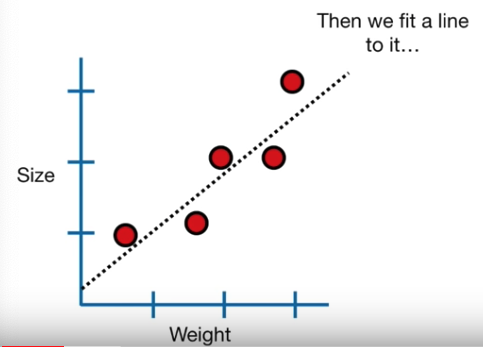

In [101]:
display(Image('linear_regression.png'))

### Logistic Regression

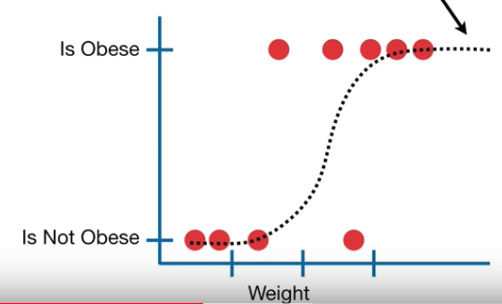

In [102]:
display(Image('logistic_regression.png'))

In [103]:
from sklearn import linear_model

clf = linear_model.LogisticRegression(solver='newton-cg')
clf.fit(x_train, y_train)
print(clf)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)


Will will be using accuracy_score as an evaluation metric.

See https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html

Intuition about Precision and Accuracy

See https://en.wikipedia.org/wiki/Accuracy_and_precision

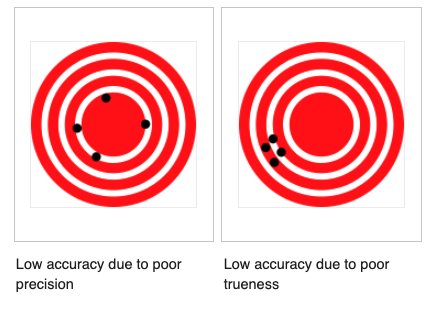

In [104]:
display(Image('precision_trueness.png'))

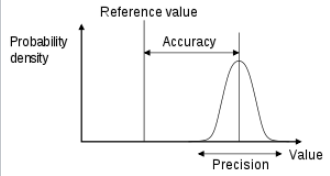

In [105]:
display(Image('precision_accuracy.png'))

In [106]:
y_predicted_train = clf.predict(x_train)
accuracy_train = accuracy_score(y_train, y_predicted_train)
print (f"\nTraining Accuracy: {accuracy_train:.3f}")


Training Accuracy: 0.848


In [107]:
precision_train = precision_score(y_train, y_predicted_train)
print ("\nTraining Precision: {0:.3f}".format(precision_train))


Training Precision: 0.738


## Weights and intercept of the learnt model

In [108]:
model_coef_df = pd.DataFrame(zip(clf.coef_[0], input_features_cat), columns=['Coefficient', 'Feature'])
model_coef_df.sort_values(['Coefficient'], ascending=[False], inplace=True)
model_coef_df.head(10)

,Coefficient,Feature
13,2.048798,education=Doctorate
21,1.874330,marital-status=Married-AF-spouse
17,1.870302,education=Prof-school
15,1.413043,education=Masters
22,1.315848,marital-status=Married-civ-spouse
12,1.090699,education=Bachelors
70,0.910066,occupation=Exec-managerial
47,0.789605,native-country=Italy
79,0.767574,occupation=Tech-support
77,0.762992,occupation=Protective-serv


In [109]:
print(f"Intercept Coefficient: {float(clf.intercept_):.3f}")

Intercept Coefficient: -5.738


# Validation

## Accuracy of a baseline classifier (ratio of the majority class)

In [110]:
baseline = (max(y_validation.values.tolist().count(1), y_validation.values.tolist().count(0))
            / len(y_validation))
print("Baseline: {0:.3f}".format(baseline))

Baseline: 0.746


## For each data point in the validation dataset, use model to predict the probability that it belongs to the positive class

Logistic regression outputs a predicted probability that a data point belongs to the positive class (>50).

In [111]:
probs_ = clf.predict_proba(x_validation)
probs_y = list(zip(probs_[:, 1], y_validation))
y_0 = [ a for (a,b) in probs_y if b==0]
y_1 = [ a for (a,b) in probs_y if b==1]  

## Classify validation dataset, considering default probability threshold (0.5), and evaluate classification results

To actually make your class predictions, you might set your "threshold" at 0.5 and classify everything above 0.5 as positive_class and everything below 0.5 as negative class, which is what most classification methods will do by default. 

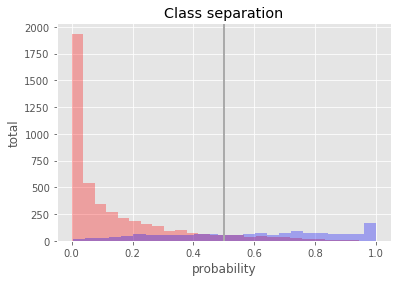

In [112]:
plot_class_separation(y_0, y_1, 25, 0.5)
show_evaluation_metrics_logistics(clf, 0.5, x_validation, y_validation)

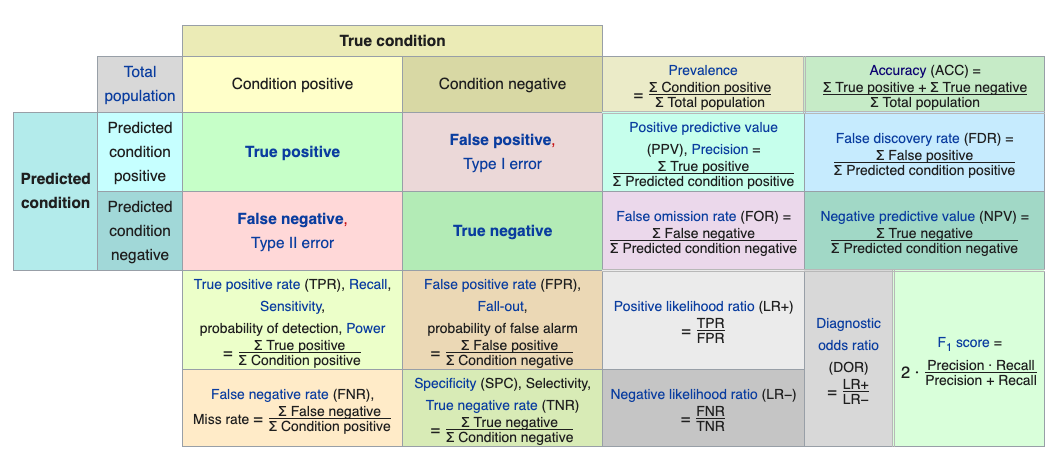

In [113]:
display(Image('confusion.png'))

## Is threshold=0.5  the "best" threshold?
### Choose the "best" threshold using the validation set
How many true positive classifications can be gained (true positives) as you allow for more and more false positives (by decreasing the "threshold")?

The best threshold depends on the domain!

In [114]:
from ipywidgets.widgets.interaction import interact, fixed
threshold_slider1 = FloatSlider(min=0.0, max=1.0, step=0.01, value=0.5)

interact(interactive_class_separation, 
       model=fixed(clf), 
       control_label=fixed('Threshold'),
       num_bins=fixed(25),
       cursor=threshold_slider1)


interactive(children=(FloatSlider(value=0.5, description='cursor', max=1.0, step=0.01), Output()), _dom_classe…

<function __main__.interactive_class_separation(model, control_label, num_bins, cursor)>

## ROC curve 
It shows how many true positive classifications can be gained (true positives) as you allow for more and more false positives (by decreasing the "threshold")

The best threshold depends on the domain!

See https://en.wikipedia.org/wiki/Receiver_operating_characteristic

In [119]:

fpr, tpr, thresholds = roc_curve(y_validation, probs_[:, 1])

from ipywidgets.widgets.interaction import interact, fixed
#threshold_slider_roc = FloatSlider(min=0.0, max=1.0, step=0.01, value=0.5)

interact(interactive_roc, 
       model=fixed(clf), 
       control_label=fixed('Threshold'),
       cursor=fixed(threshold_slider1.value))


interactive(children=(Output(),), _dom_classes=('widget-interact',))

<function __main__.interactive_roc(model, control_label, cursor)>

# Test

## Learn a model using the whole input data (training + validation) 

In [120]:
clf_best = linear_model.LogisticRegression(solver='newton-cg')
clf_best.fit(x_input, y_input)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

## Use model to predict the probability that data point belongs to the positive class

In [121]:
probs_teste_ = clf_best.predict_proba(x_test)
probs_teste_y = list(zip(probs_teste_[:, 1], y_test))
y_teste_0 = [a for (a,b) in probs_teste_y if b==0]
y_teste_1 = [a for (a,b) in probs_teste_y if b==1]

## Classify test datset using threshold from validation step

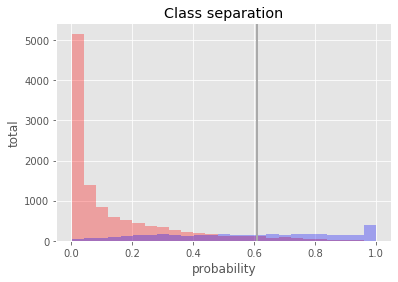

In [122]:
plot_class_separation(y_teste_0, y_teste_1, 25, threshold_slider1.value)
show_evaluation_metrics_logistics(clf_best, 
                                  threshold_slider1.value,  
                                  x_test, 
                                  y_test)

#### References:
  * Logistic Regression: https://en.wikipedia.org/wiki/Logistic_regression
  * Efficiency Metrics: https://en.wikipedia.org/wiki/Evaluation_of_binary_classifiers
  * Confusion Matrix: https://en.wikipedia.org/wiki/Confusion_matrix
  * ROC Curve: https://en.wikipedia.org/wiki/Receiver_operating_characteristic
  * Logistic Regression in R: http://www.ats.ucla.edu/stat/r/dae/logit.htm
  * Logistic Regression in Python: 
      - http://blog.yhat.com/posts/logistic-regression-and-python.html
      - http://nbviewer.jupyter.org/gist/justmarkham/6d5c061ca5aee67c4316471f8c2ae976